# Stop and Frisk in NYC

The New York Police Department publicly releases data concerning its use of "stop & frisk" each year. "Stop & Frisk" is the NYPD's practice of temporarily detaining, questioning, and at times searching civilians on the street for weapons and other contraband. The practice is controversial, as many claim it unfairly targets certain minorities and neighborhoods. For this analysis, I will combine the 2016 NYC Stop and Frisk data with the 2016 Economic Profile of NYC's NTAs. NTAs are Neighborhood Tabulation Areas as created by the NYC Department of City Planning using whole census tracts from the 2010 Census as building blocks. Using the Economic Profiles of the 

##### Hypothesis:
Using economic data concerning the population living in each of NYC's Neighborhood Tabulation Areas, we can determine which neighborhoods of NYC are most targeted for stop and frisk.

###### Data Sources:
Stop and Frisk Data: https://data.cityofnewyork.us/Public-Safety/The-Stop-Question-and-Frisk-Data/ftxv-d5ix

Economic Data: https://data.cityofnewyork.us/City-Government/Demographic-Social-Economic-and-Housing-Profiles-b/kvuc-fg9b

NTA Data (to determine which NTA each police stop was in): https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import re
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
police_stops = pd.read_csv('sqf-2016.csv')

/Users/briansrebrenik/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,1,2,3,4,8,18,19,73,74,84,85,86,103,110,111) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
police_stops.head()

,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,crimsusp,...,zip,addrpct,sector,beat,post,xcoord,ycoord,dettypCM,lineCM,detailCM
0,2016,41,22,2072016,100,A,O,P,1,BURG,...,,41,B,2,,1013353,234000,CM,1,14
1,2016,10,22,2182016,30,1,O,P,8,MISDEMEANOR,...,,10,D,,,983478,212373,CM,1,28
2,2016,66,1,1012016,30,1,I,P,2,FEL,...,,66,F,,,988340,172111,CM,1,9
3,2016,47,18,1012016,40,1,O,H,1,FEL,...,,47,C,,,,,CM,1,20
4,2016,79,1,1012016,50,1,O,P,3,D.W.I.,...,,79,G,4,,998197,187413,CM,1,112


In [4]:
police_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12405 entries, 0 to 12404
Columns: 112 entries, year to detailCM
dtypes: object(112)
memory usage: 10.6+ MB


The police data includes addresses for all of the stops. The NTA data gives the shape of each NTA by its coordinates. The function below is used to collect the coordinates of all of the police stops (using Google Maps API) so I can label each stop with the proper NTA.

In [5]:
#API_key = *********
def get_coordinates():
    all_coordinates = []
    for i in tqdm(range(len(police_stops))):
        try:
            sn = police_stops.stname.loc[i]
            si = police_stops.stinter.loc[i]
            cn = police_stops.city.loc[i]
            r = requests.get(
            f'https://maps.googleapis.com/maps/api/geocode/json?address={sn}+and+{si},+{cn},+NY&key={API_key}'
            ).json()
            coordinates = r['results'][0]['geometry']['location']
            all_coordinates.append(coordinates)
        except:
            all_coordinates.append('NA')
    return all_coordinates

In [6]:
# coordinates = get_coordinates()
# police_stops['coordinates'] = coordinates
# police_stops.to_csv('police_stops.csv')

In [7]:
police_stops = pd.read_csv('police_stops.csv')
police_stops.head()

/Users/briansrebrenik/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1,2,3,4,5,9,19,20,74,75,85,86,87,104,111,112) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,...,addrpct,sector,beat,post,xcoord,ycoord,dettypCM,lineCM,detailCM,coordinates
0,0,2016,41,22,2072016,100,A,O,P,1,...,41,B,2,,1013353,234000,CM,1,14,"{'lat': 40.81312200000001, 'lng': -73.8942721}"
1,1,2016,10,22,2182016,30,1,O,P,8,...,10,D,,,983478,212373,CM,1,28,"{'lat': 40.7475915, 'lng': -73.9980082}"
2,2,2016,66,1,1012016,30,1,I,P,2,...,66,F,,,988340,172111,CM,1,9,"{'lat': 40.6387311, 'lng': -73.9846689}"
3,3,2016,47,18,1012016,40,1,O,H,1,...,47,C,,,,,CM,1,20,"{'lat': 40.8839888, 'lng': -73.8421695}"
4,4,2016,79,1,1012016,50,1,O,P,3,...,79,G,4,,998197,187413,CM,1,112,"{'lat': 40.6829528, 'lng': -73.93336649999999}"


In [8]:
#loading coordinate info for NTAs
nta = pd.read_csv('nynta.csv')
nta.head()

,the_geom,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Area
0,MULTIPOLYGON (((-73.94732672160586 40.62916656...,3,Brooklyn,47,BK43,Midwood,27996.591274,3.579964e+07
1,MULTIPOLYGON (((-73.94193078816201 40.70072523...,3,Brooklyn,47,BK75,Bedford,29992.919174,3.262983e+07
2,MULTIPOLYGON (((-73.89138023380268 40.86170058...,2,Bronx,5,BX40,Fordham South,15878.272921,6.307284e+06
3,MULTIPOLYGON (((-73.9760493559142 40.631275905...,3,Brooklyn,47,BK88,Borough Park,39247.227722,5.400502e+07
4,MULTIPOLYGON (((-73.90855790522774 40.65209593...,3,Brooklyn,47,BK96,Rugby-Remsen Village,30957.853395,3.270695e+07


The following steps involve labeling each police report with the proper NTA. Column "the_geom" in the NTA table above contains the shape of each NTA neighborhood. Using the Shapely Python package, I will convert these coordinates into polygon objects. Using this objects, I can see which NTA's "contain" each police stop.

In [9]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [10]:
shape = []
#using regex to pull coordinates of each NTA
for i in range(len(nta)):
    coord = re.findall('(-?\d\d.\d*\s-?\d\d.\d*)', nta.the_geom.loc[i])
    coord = [x.split() for x in coord]
    coord = [(float(x[0]), float(x[1])) for x in coord]
    shape.append(coord)
#converting each array of coordinates into Polygon object
shape = [Polygon(x) for x in shape]
#dictionary of each NTA and its coordinates
ntas = dict((x[0], x[1]) for x in zip(list(nta.NTAName), shape))

In [11]:
reports_ntas = []
for i in tqdm(range(len(police_stops))):
    try:
        lng = float(re.findall('(-?\d{2}\.\d*)', police_stops.coordinates.loc[i])[1])
        lat = float(re.findall('(-?\d{2}\.\d*)', police_stops.coordinates.loc[i])[0])
        coords = Point(lng, lat)
        find = False
        for x in ntas.keys():
            if ntas[x].contains(coords):
                reports_ntas.append(x)
                find= True
                break
        if not find:
            reports_ntas.append('NA')
    except:
        reports_ntas.append('NA')

100%|██████████| 12405/12405 [00:11<00:00, 1036.37it/s]


In [13]:
police_stops['nta'] = reports_ntas
police_stops.head()

,Unnamed: 0,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,...,sector,beat,post,xcoord,ycoord,dettypCM,lineCM,detailCM,coordinates,nta
0,0,2016,41,22,2072016,100,A,O,P,1,...,B,2,,1013353,234000,CM,1,14,"{'lat': 40.81312200000001, 'lng': -73.8942721}",Hunts Point
1,1,2016,10,22,2182016,30,1,O,P,8,...,D,,,983478,212373,CM,1,28,"{'lat': 40.7475915, 'lng': -73.9980082}",Hudson Yards-Chelsea-Flatiron-Union Square
2,2,2016,66,1,1012016,30,1,I,P,2,...,F,,,988340,172111,CM,1,9,"{'lat': 40.6387311, 'lng': -73.9846689}",Borough Park
3,3,2016,47,18,1012016,40,1,O,H,1,...,C,,,,,CM,1,20,"{'lat': 40.8839888, 'lng': -73.8421695}",Eastchester-Edenwald-Baychester
4,4,2016,79,1,1012016,50,1,O,P,3,...,G,4,,998197,187413,CM,1,112,"{'lat': 40.6829528, 'lng': -73.93336649999999}",Crown Heights North


#### Bar Chart of Locations of Stop and Frisk

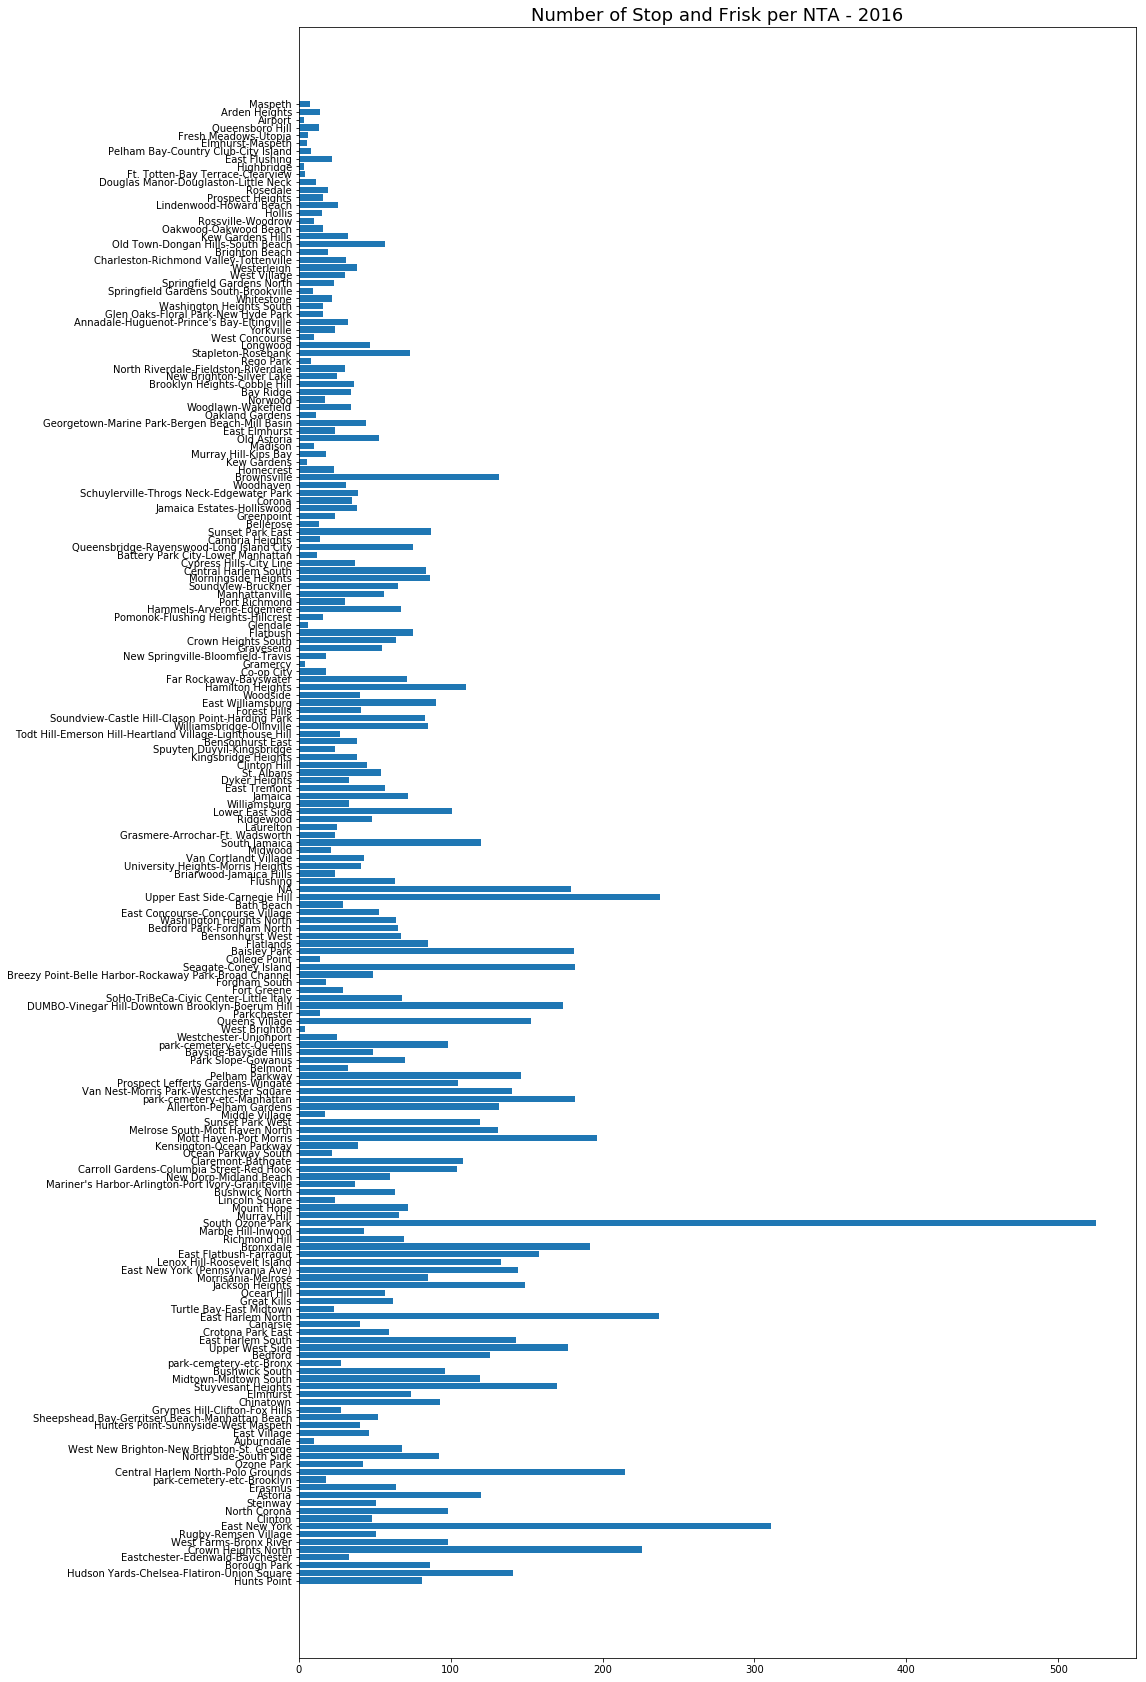

In [18]:
nta_stop_count = Counter(list(police_stops.nta))
plt.figure(figsize=(15,30))
plt.barh(y=list(nta_stop_count.keys()), width = list(nta_stop_count.values()),)
plt.title('Number of Stop and Frisk per NTA - 2016', size=18)
plt.show()

#### Distribution of total stop and frisk count by NTA

/Users/briansrebrenik/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


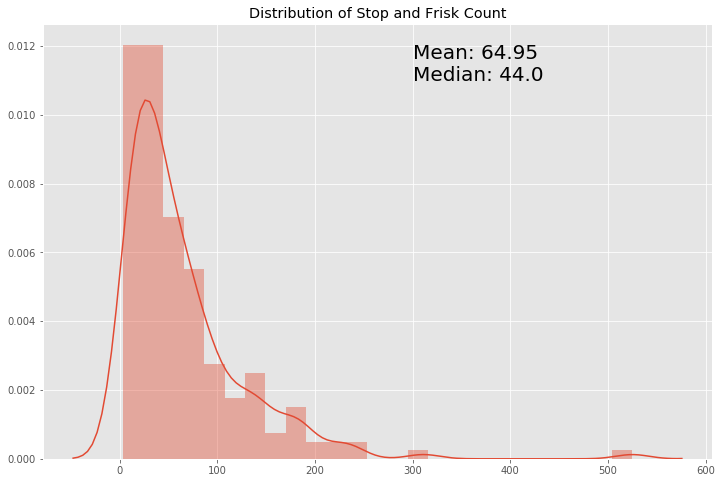

In [33]:
mean_count = np.mean(list(nta_stop_count.values()))
median_count = np.median(list(nta_stop_count.values()))
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
sns.distplot(list(nta_stop_count.values()))
plt.title('Distribution of Stop and Frisk Count')
plt.text(300, .011, f'Mean: {round(mean_count,2)}\nMedian: {median_count}', size=20)
plt.show()